# Computer Vision, Dr. Aygul Zagidullina

# Intuitions on Convolutions

Let's build some intuitions about the **`convolution operations`**.

🎯 <b><u>Goals</u>:</b>
- **Understand convolution operations**
- **Visualize**
    - convolution kernels
    - the effects of a convolution kernel applied on images

<hr>

🖼 <b><u>Convolutional Neural Networks are Neural Networks specifically designed to work on images</u></b>.

- 🧮 This is made possible thanks to **`convolution operations`**.

- 🔎 These specific mathematical operations apply a **`filter`** (i.e. a set of **`kernels`**, one per channel) to an input image and create an **`output representation`**. For Convolutional Neural Networks, this can also be called:
    * a **`"convoluted representation/feature"`**,
    * or a **`"convolution"`**,
    * or also an **`"activation"`** (as it corresponds to the activation of a given layer).

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/CNN/convolution.png" width="300">

---

❗️ <b><u>Remarks</u></b> ❗️

* It is important to understand that **the same kernel (i.e. the same weights) is applied to different areas of the images**.

* This is completely different from Dense Neural Networks:
    * In `Dense/"Fully Connected" Neural Networks`, each weight of a given neuron is related to only one input coordinate (which, in images, would correspond to one pixel).
    * In `Convolution Neural Networks`, the weights of a kernel are not applied to only one feature input, i.e. one pixel, but to different pixels, "step by step"!

👉 You can think of each kernel (or each filter in the case of colored images) as a **`magnifying glass`** through which you see the image. Similarly to your eyes, kernels cannot capture everything in a picture at once, but they ***scan different parts of a picture to understand the whole picture that is being analyzed***.

🎬 So let's have a closer look at `convolution operations`, and their impact in `Convolutional Neural Networks`.

## (0) The dataset

Let's download the data.

In [ ]:
!unzip -q circles-and-triangles.zip

First, let's use the following function `load_data` to... load the data.


In [ ]:
import os
import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

def load_data(path):
    nb_circles = 100
    nb_triangles = 100

    X, y = [], []

    for i in range(nb_circles):
        c_path = os.path.join(path, 'circles', f'circle_{i}.png')
        X.append(np.array(Image.open(c_path))[:, :, :1])
        y.append(0)

    for i in range(nb_triangles):
        t_path = os.path.join(path, 'triangles', f'triangle_{i}.png')
        X.append(np.array(Image.open(t_path))[:, :, :1])
        y.append(1)

    c = list(zip(X, y))
    np.random.shuffle(c)
    X, y = zip(*c)

    return np.array(X), np.array(y)

X, y = load_data("data")

❓ **Question about the shape** ❓

* How many images do we have?
* What are their dimensions?
* Can we comment on the number of channels?

In [ ]:
X.shape

(200, 76, 78, 1)

<details>
    <summary><i>About the number of channels:</i></summary>
       
  We need only one channel to compute the "*blackness intensity*" of a pixel with 0 corresponding to a black pixel and 1 corresponding to a white pixel. The last dimension corresponds to some kind of  "Black to white channel".
        
🎨 For colored images, the last dimension would be equal to 3 for `Red, Green, Blue (RGB)`

👉 Have fun playing with the intensities of Red, Green and Blue <a href="https://www.w3schools.com/colors/colors_rgb.asp">`here`</a>
        
        
</details>        

❓ **Question about the normalization** ❓

Do these images need some normalization?

In [ ]:
np.min(X), np.max(X)


(0, 255)

👀 Let's have a look at some images with `plt.imshow` and show their respective labels.

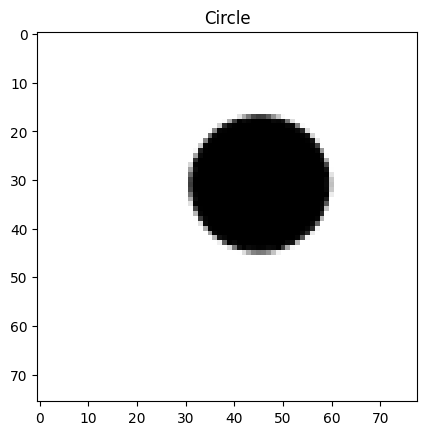

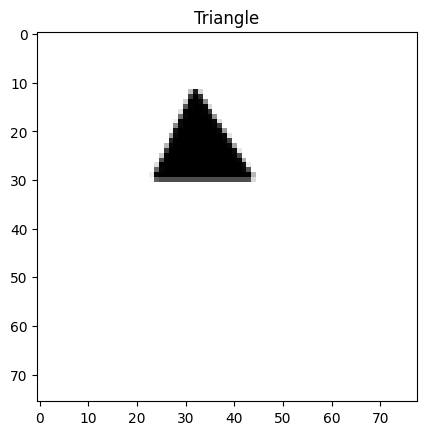

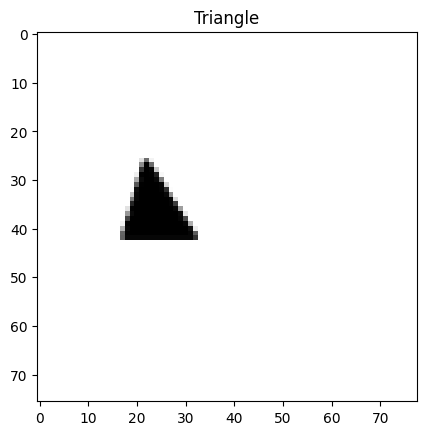

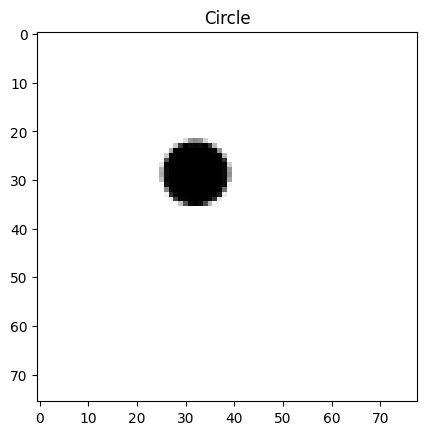

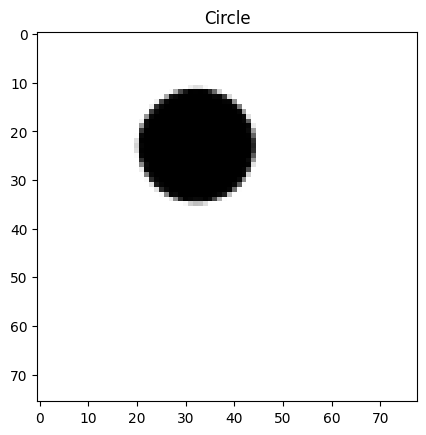

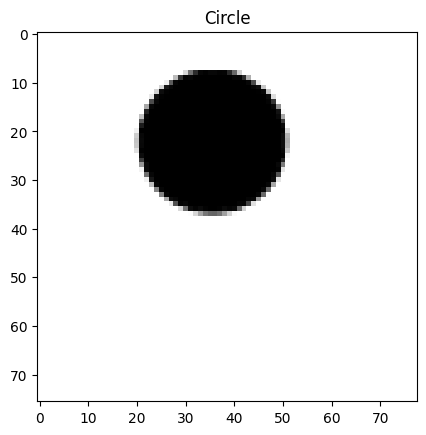

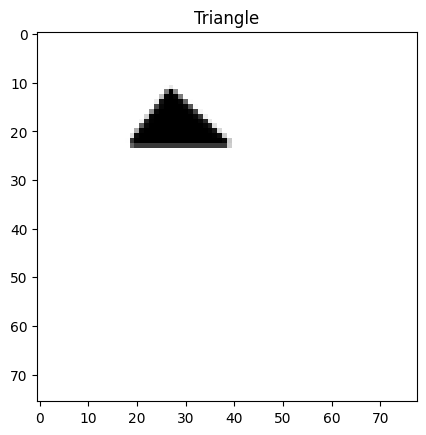

In [ ]:
for iter_, (image, label) in enumerate(zip(X, y)):
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.title('Triangle' if label == 1 else 'Circle')
    plt.show()

    if iter_ > 5:
        break

❓ **Question: How many classes are we going to predict** ❓

_This information will help us design the last layer of your Convolutional Network_

In [ ]:
np.unique(y, return_counts = True)
# Two categories to predict

(array([0, 1]), array([100, 100]))

<details>
    <summary><i>Answer</i></summary>
        
- We have only two categories: Triangle (1) and Circle (0).  
- Hence, it is a binary classification and we will need only one single neuron in the predictive layer.
        
</details>        

## (1) Kernels & Convolutions

🎁 The following function **`compute_convolution`** performs a **convolution operation** $ \Leftrightarrow $ i.e. *it applies a kernel to an image*.

❓ **Question about the `compute_convolution` function** ❓

Run it and try to understand the different steps of this function.

In [ ]:
def compute_convolution(input_image, kernel):
    # Parameters
    kernel = np.array(kernel)
    kernel_height, kernel_width = kernel.shape

    img = np.squeeze(input_image) # Removes dimensions of size 1
    img_height, img_width = img.shape

    output_image = []

    for x in range(img_height - kernel_height + 1):
        arr = []

        for y in range(img_width - kernel_width + 1):

            a = np.multiply(img[x: x + kernel_height, y: y + kernel_width],
                            kernel)
            arr.append(a.sum())

        output_image.append(arr)

    return output_image

❓ **How does the `compute_convolution` function work in practice** ❓

1. Choose any image from the input dataset
2. Apply the `identity_kernel` to it
3. Display both the input image and the output image.
4. Do you see any differences?

In [ ]:
identity_kernel = [
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]

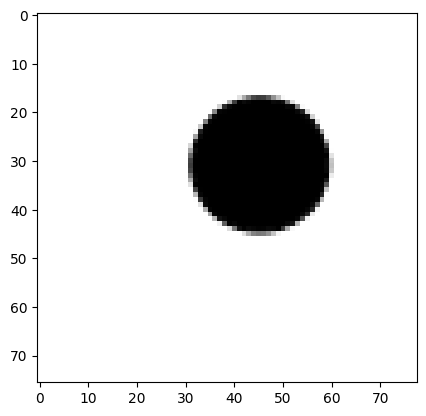

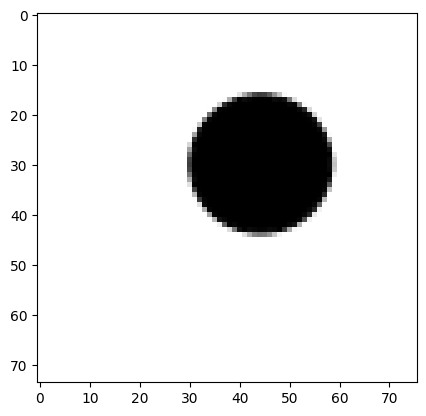

In [ ]:
input_image = X[0]
kernel = identity_kernel

output_image = compute_convolution(input_image, kernel)

# Original Image
plt.imshow(np.squeeze(X[0]), cmap='gray')
plt.show()

# Convoluted image
plt.imshow(output_image, cmap='gray')
plt.show()

<details>
    <summary><i>Answer</i></summary>
        
🧑🏻‍🏫 The previous kernel corresponds to the **`identity_kernel`**, meaning that ***the output is equal to the input***...
    
🕵🏻‍♂️ It basically did nothing to the input image. It you think about it thoroughly, that's not surprising. With this kernel, only the pixel scanned in the middle was kept and multiplied by one, the surrounding pixels were multiplied by zero.        
        
</details>        

🎁The function **`plot_convolution`** plots the output image after applying a kernel to an input image.

In [ ]:
def plot_convolution(img, kernel, activation=False):
    ''' The following printing function ease the visualization'''

    img = np.squeeze(img)
    output_img = compute_convolution(img, kernel)
    if activation:
        output_img = np.maximum(output_img, 0)

    plt.figure(figsize=(10, 5))

    ax1 = plt.subplot2grid((3,3),(0,0), rowspan=3)
    ax1.imshow(img, cmap='gray')
    ax1.title.set_text('Input image')

    ax2 = plt.subplot2grid((3,3),(1, 1))
    ax2.imshow(kernel, cmap='gray')
    ax2.title.set_text('Kernel')

    ax3 = plt.subplot2grid((3,3),(0, 2), rowspan=3)
    ax3.imshow(output_img, cmap='gray')
    ax3.title.set_text('Output image')

    for ax in [ax1, ax2, ax3]:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    plt.show()

❓ **Question** ❓ Apply `plot_convolution` with the following `kernel_1` once on an triangle and once on a circle.


In [ ]:
kernel_1 = [
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
]

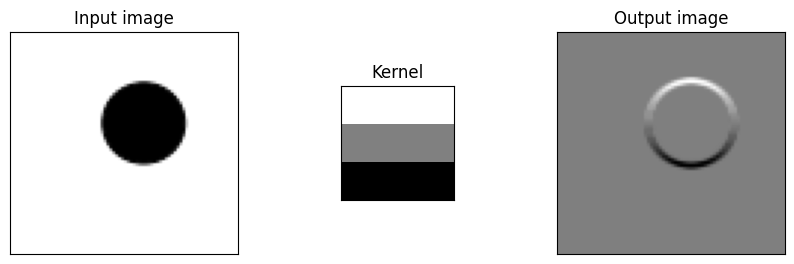

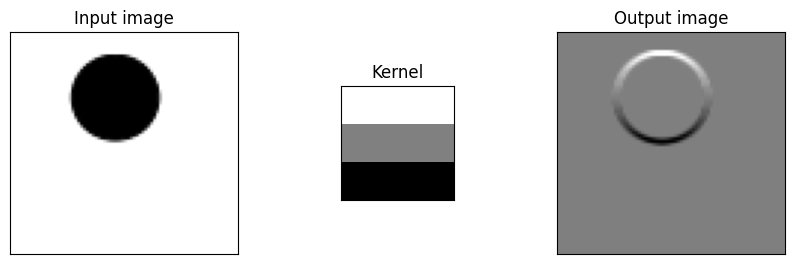

In [ ]:
plot_convolution(X[0], kernel_1)
plot_convolution(X[5], kernel_1)

👆 Let's analyze what just happened:

* White pixels correspond to high values and black pixels to low values.
* In a Neural Network, remember that we use activation functions to remove linearities.
    * *For example*, when the activation function is `relu`, you already know that it simply corresponds to setting the negative values to 0.

---

❓ **What is the impact of the activation function in a Convolutional Layer ?** ❓

Re-run the previous function `plot_convolution` with `activation` set to `True` (in this case, the activation function _is_ the relu).

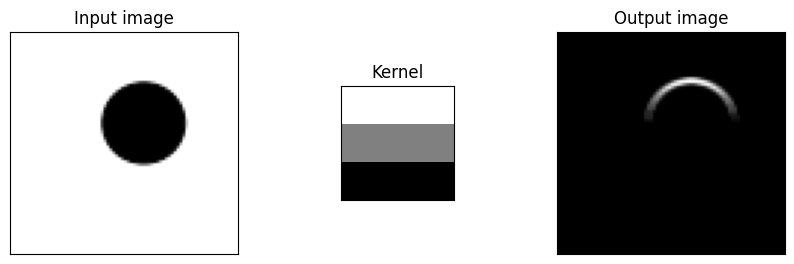

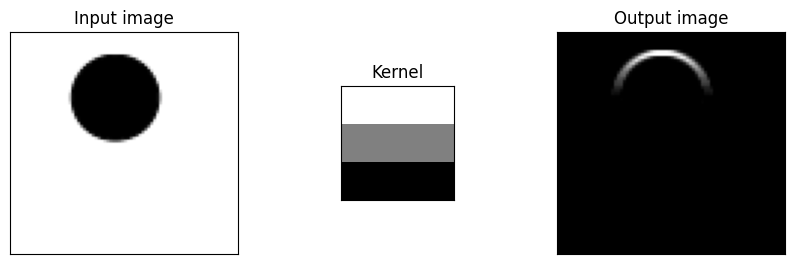

In [ ]:
plot_convolution(X[0], kernel_1, activation=True)
plot_convolution(X[5], kernel_1, activation=True)

👆 This kernel is actually highlighting the edges in a given direction.

❓ **Play with different kernels...** ❓

Try the following kernels to check the different edges they can detect.

In [ ]:
kernel_2 = [
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1],
]

kernel_3 = [
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
]

kernel_4 = [
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
]

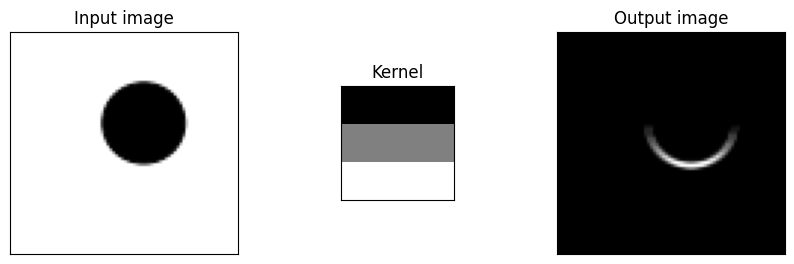

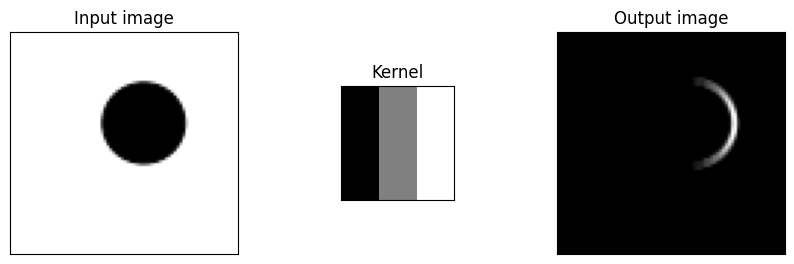

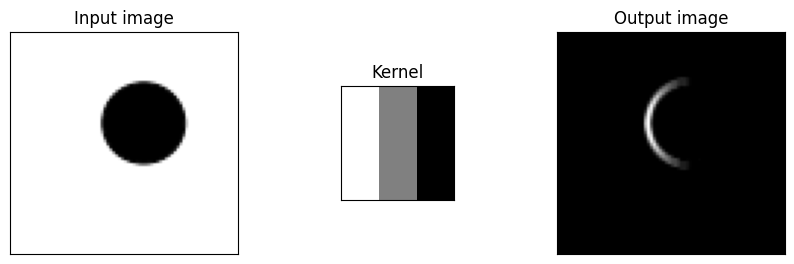

In [ ]:
plot_convolution(X[0], kernel_2, activation=True)
plot_convolution(X[0], kernel_3, activation=True)
plot_convolution(X[0], kernel_4, activation=True)

❓ **What is the effect of the kernel size** ❓

Try the _kernel_big_.

In [ ]:
kernel_big = np.array([
    np.ones((10,)),
    np.ones((10,)),
    np.ones((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.ones((10,))*-1,
    np.ones((10,))*-1,
    np.ones((10,))*-1,
])

kernel_big

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

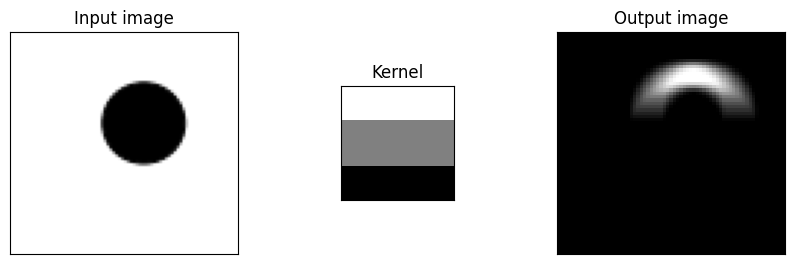

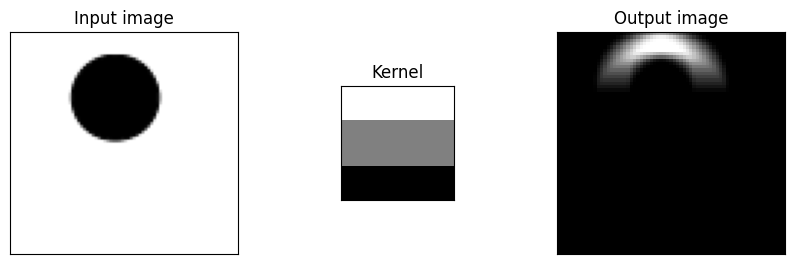

In [ ]:

plot_convolution(X[0], kernel_big, activation=True)
plot_convolution(X[5], kernel_big, activation=True)


❓ **Try another kernel**  ❓

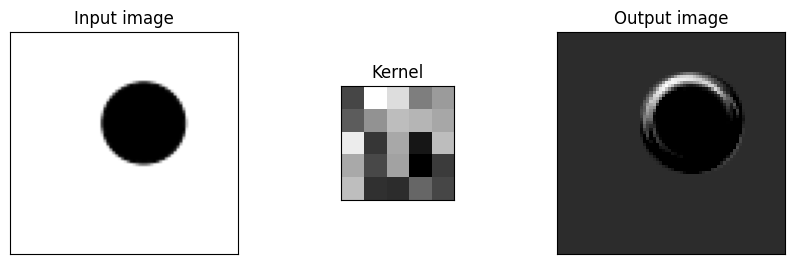

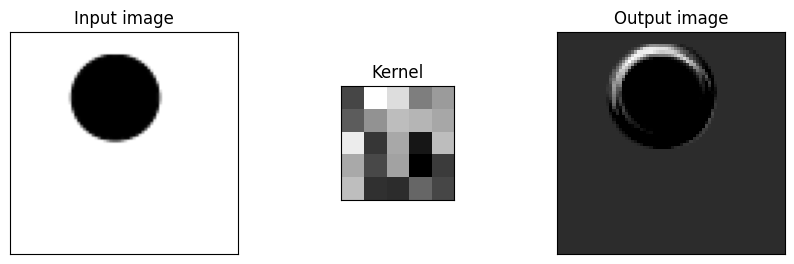

In [ ]:
random_kernel = np.random.uniform(-10, 10, (5, 5))

plot_convolution(X[0], random_kernel, activation=True)
plot_convolution(X[5], random_kernel, activation=True)


Now that you've got the idea of what a convolution operation does to an image, let's see how it goes with a "real" Convolutional Neural Network. ✅

## (2) Training a CNN to detect triangles and circles

### (2.1) Architecture


❓ **Question: Designing a CNN** ❓

Write a Convolutional Network that has
- a Convolutional Layer with 16 filters with $ (4, 4) $ kernels.
- a Convolutional Layer with 32 filters with $ (3, 3) $ kernels.
- a Convolutional Layer with 64 filters with $ (3, 3) $ kernels.
- a Convolutional Layer with 64 filters with $ (2, 2) $ kernels.

with:
- A Max-Pooling Layer (with a $ (2, 2) $ pool-size) after each convolution.
- A Hidden Dense Layer with the size of your choice, be reasonable:
    - after the flattening part
    - but before the last layer


Also, make sure to compile your model with the appropriate parameters

In [ ]:
from tensorflow.keras import layers, models

def initialize_model():


    model = models.Sequential()

    model.add(layers.Conv2D(16, (4, 4), input_shape = (76, 78, 1), activation = 'relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (2, 2), activation = 'relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(units = 10, activation = 'relu'))
    model.add(layers.Dense(units = 1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics =['accuracy'])



    return model

2024-12-05 20:09:15.951726: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### (2.2) Training

In [ ]:
model = initialize_model()
model.summary()

/Users/arnaud/miniconda3/envs/siamese/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 75, 16)     │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 35, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,637 (178.27 KB)

 Trainable params: 45,637 (178.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Parameters on the first Conv2D
( (4*4) * 1 + 1) * 16

272

In [ ]:
# Parameters on the second Conv2D
( (3*3) * 16 + 1) * 32

4640

In [ ]:
# Parameters on the third Conv2D
( (3*3) * 32 + 1) * 64


18496

In [ ]:
# Parameters on the fourth and last Conv2D
( (2*2) * 64 + 1) * 64

16448

❓ **Question: Training the CNN** ❓

* Fit the model. We achieve an accuracy of *at least* 90%.

    * When you reach such a high score, it may sound suspicious and you would probably ask yourself whether the model is overfitting or not... but let's ignore it for this exercise 😏

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5)

model = initialize_model()

history = model.fit(X, y,
                    validation_split = 0.3,
                    batch_size = 16,
                    epochs=50,
                    callbacks=[es],
                    verbose = 1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.4631 - loss: 6.0792 - val_accuracy: 0.5667 - val_loss: 0.7108
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5224 - loss: 0.6748 - val_accuracy: 0.6833 - val_loss: 0.5936
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6026 - loss: 0.5954 - val_accuracy: 0.6833 - val_loss: 0.4880
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6752 - loss: 0.4748 - val_accuracy: 0.8333 - val_loss: 0.3927
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9328 - loss: 0.2662 - val_accuracy: 0.8333 - val_loss: 0.4587
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9872 - loss: 0.1407 - val_accuracy: 0.9000 - val_loss: 0.2740
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9864 - loss: 0.0742 - val_accuracy: 0.9167 - val_loss: 0.1970
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9632 - loss: 0.0789 - val_accuracy: 0.9667 - val_loss: 0.1423


🎁 We have the `plot_loss_accuracy` function.

❓ **Question: does the CNN converge** ❓

_Also, do you see any sign of overfitting?_

In [ ]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

    plt.show()

We are not overfitting ;)


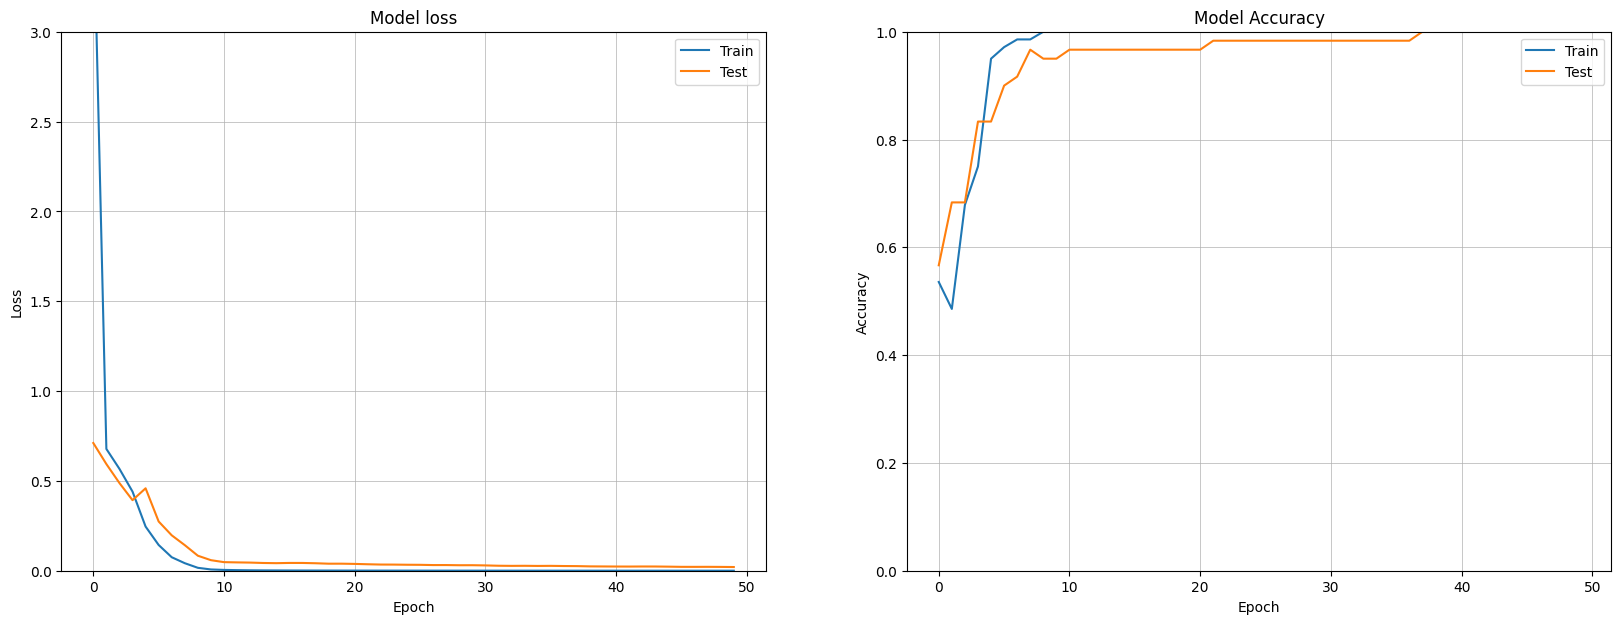

In [ ]:
plot_loss_accuracy(history)

print("We are not overfitting ;)")

### 🎁 📚 (2.3) Deeper understanding of CNNs

👩🏻‍🏫 For any Sequential Neural Network (Dense or Convolutional), you can:
- print the **`.summary()`** to display the layers and the number of weights/parameters involved
- access the different **`.layers`** of your model

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 73, 75, 16)     │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 35, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,913 (534.82 KB)

 Trainable params: 45,637 (178.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,276 (356.55 KB)

In [ ]:
model.layers

[<Conv2D name=conv2d_4, built=True>,
 <MaxPooling2D name=max_pooling2d_4, built=True>,
 <Conv2D name=conv2d_5, built=True>,
 <MaxPooling2D name=max_pooling2d_5, built=True>,
 <Conv2D name=conv2d_6, built=True>,
 <MaxPooling2D name=max_pooling2d_6, built=True>,
 <Conv2D name=conv2d_7, built=True>,
 <MaxPooling2D name=max_pooling2d_7, built=True>,
 <Flatten name=flatten_1, built=True>,
 <Dense name=dense_2, built=True>,
 <Dense name=dense_3, built=True>]

 With the following table, we will have a better overview of the different weights, kernels and filters involved in the CNN you've built earlier:

| layer_number | convolution_layer | kernel_number | channel_number |
|--------------|-------------------|---------------|----------------|
| 0            | conv2D no 1       | 16            | 1              |
| 2            | conv2D no 2       | 32            | 16             |
| 4            | conv2D no 3       | 64            | 32             |
| 6            | conv2D no 4       | 64            | 64             |

#### (2.3.1) Kernels

🧑🏻‍🏫 It is possible to **retrieve the values of all the kernels for each layer after training a CNN**.

👉 Let's focus first on the different parameters (**`.weights`**) of the first convolutional layer.

In [ ]:
# Accessing the first convolutional layer of the CNN
first_convolutional_layer = model.layers[0]
first_convolutional_layer

<Conv2D name=conv2d_4, built=True>

In [ ]:
# Weights of the first convolutional layer of the CNN - which was trained/optimized
first_convolutional_layer.weights[0].shape

TensorShape([4, 4, 1, 16])

👆 `TensorShape[4, 4, 1, 16]` represents:
- the weights of each kernel (size `4` $\times$ `4`)
- there was only `1` channel (single B&W input)
- and we have decided to apply `16` different kernels in this layer!

In [ ]:
# Biases of the first convolutional layer of the CNN - which was trained/optimized
first_convolutional_layer.weights[1].shape

TensorShape([16])

👆 Let's not forget the biases, one per new channel in the output image!

In [ ]:
# Notice that we have indeed 256 weights + 16 biases = 272 parameters for the first convolutional layer
4*4*1*16+16

272

👉 What are the parameters for the other layers of this Network ❓

In [ ]:
# Accessing the second convolutional layer of the CNN
second_convolutional_layer = model.layers[2]
second_convolutional_layer

<Conv2D name=conv2d_5, built=True>

In [ ]:
# Weights of the second convolutional layer of the CNN - which was trained/optimized
second_convolutional_layer.weights[0].shape

TensorShape([3, 3, 16, 32])

In [ ]:
# Biases of the second convolutional layer of the CNN - which was trained/optimized
second_convolutional_layer.weights[1].shape

TensorShape([32])

In [ ]:
# Notice that we have indeed 4608 weights + 32 biases = 4640 parameters for the third convolutional layer
3*3*16*32+32

4640

In [ ]:
# Accessing the third convolutional layer of the CNN
third_convolutional_layer = model.layers[4]
third_convolutional_layer

<Conv2D name=conv2d_6, built=True>

In [ ]:
# Weights of the third convolutional layer of the CNN - which was trained/optimized
third_convolutional_layer.weights[0].shape

TensorShape([3, 3, 32, 64])

In [ ]:
# Biases of the third convolutional layer of the CNN - which was trained/optimized
third_convolutional_layer.weights[1].shape

TensorShape([64])

In [ ]:
# Notice that we have indeed 18432 weights + 64 biases = 18496 parameters for the fourth convolutional layer
3*3*32*64+64

18496

In [ ]:
# Accessing the fourth convolutional layer of the CNN
fourth_convolutional_layer = model.layers[6]
fourth_convolutional_layer

<Conv2D name=conv2d_7, built=True>

In [ ]:
# Weights of the fourth convolutional layer of the CNN - which was trained/optimized
fourth_convolutional_layer.weights[0].shape

TensorShape([2, 2, 64, 64])

In [ ]:
# Biases of the fourth convolutional layer of the CNN - which was trained/optimized
fourth_convolutional_layer.weights[1].shape

TensorShape([64])

In [ ]:
# Notice that we have indeed 16384 weights + 64 biases = 16448 parameters for the fourth convolutional layer
(2*2*64+1)*64

16448

🚀 Now that we know how to access the trained weights of each kernel for every convolutional layer, we are going to investigate how they impact the analysis of images.

* 🪄 Using **`plot_convolution(activation = True)`**, let's display the 16 kernels from the first convolutional layer, alongside with the activation output, to see what the model has learned from the images in this layer.

------------------------- Effect of the kernel number 0 -------------------------


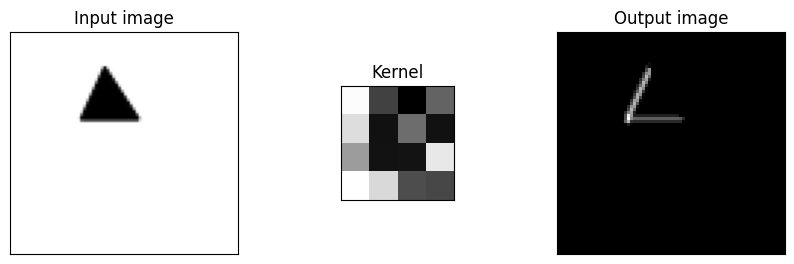

------------------------- Effect of the kernel number 1 -------------------------


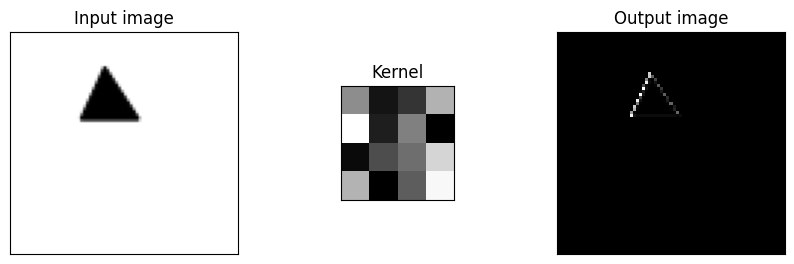

------------------------- Effect of the kernel number 2 -------------------------


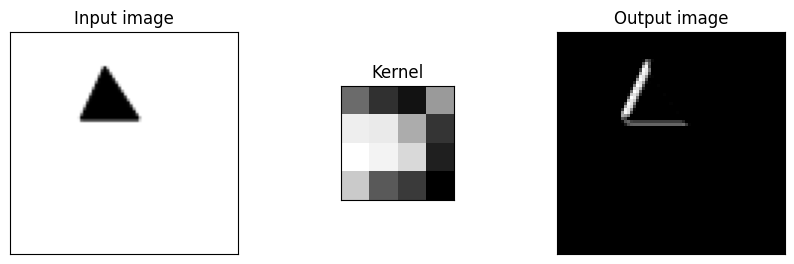

------------------------- Effect of the kernel number 3 -------------------------


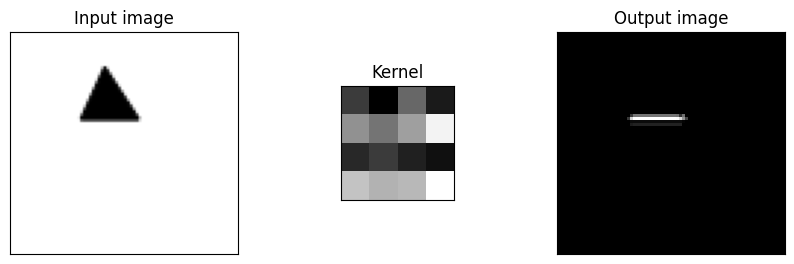

------------------------- Effect of the kernel number 4 -------------------------


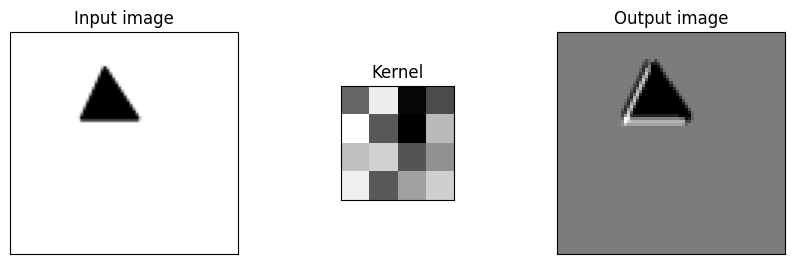

------------------------- Effect of the kernel number 5 -------------------------


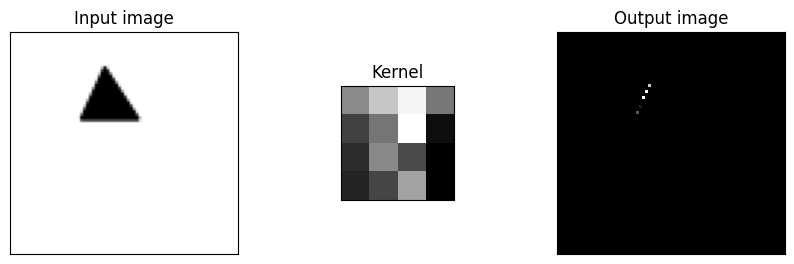

------------------------- Effect of the kernel number 6 -------------------------


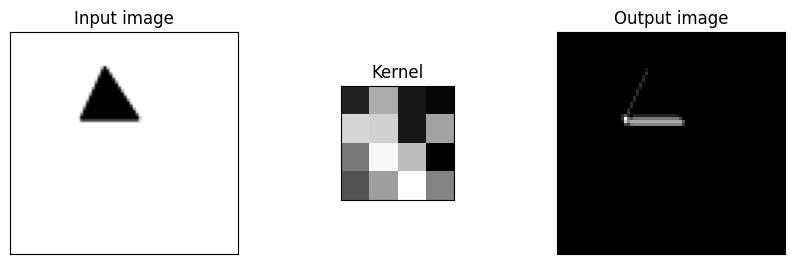

------------------------- Effect of the kernel number 7 -------------------------


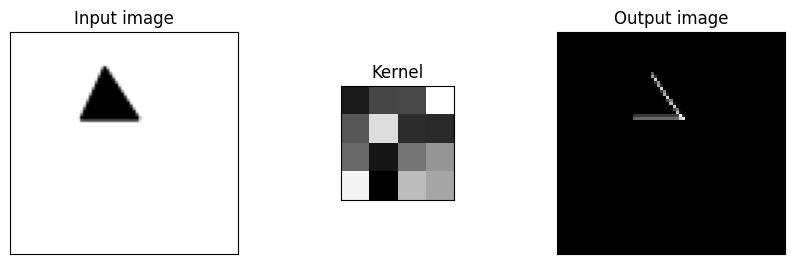

------------------------- Effect of the kernel number 8 -------------------------


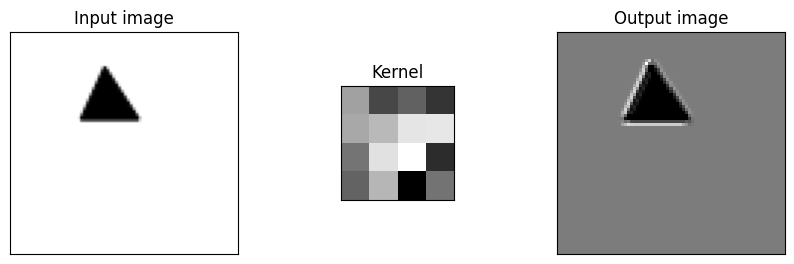

------------------------- Effect of the kernel number 9 -------------------------


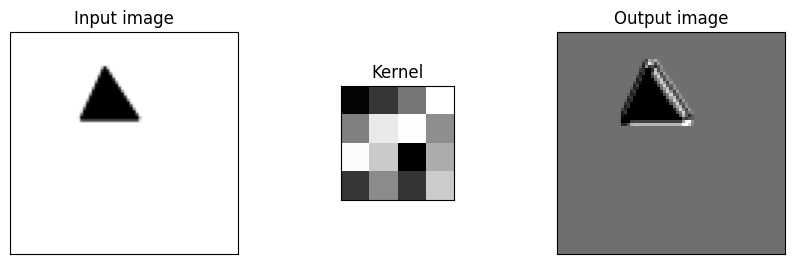

------------------------- Effect of the kernel number 10 -------------------------


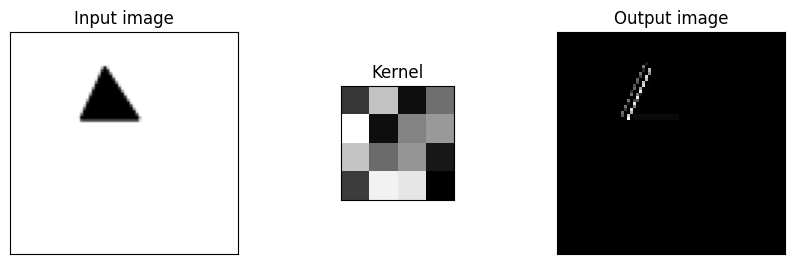

------------------------- Effect of the kernel number 11 -------------------------


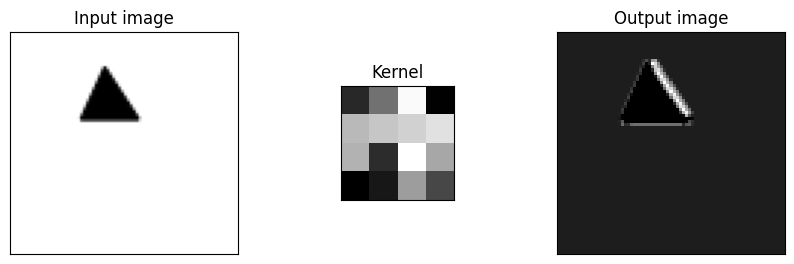

------------------------- Effect of the kernel number 12 -------------------------


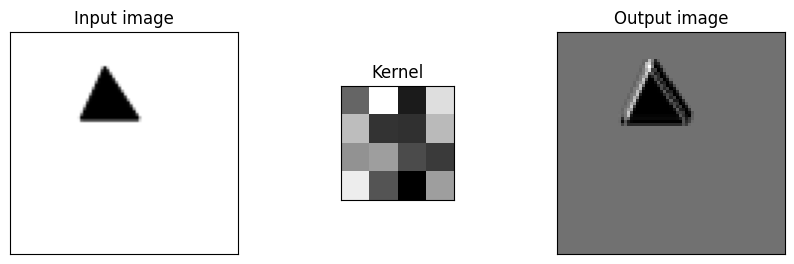

------------------------- Effect of the kernel number 13 -------------------------


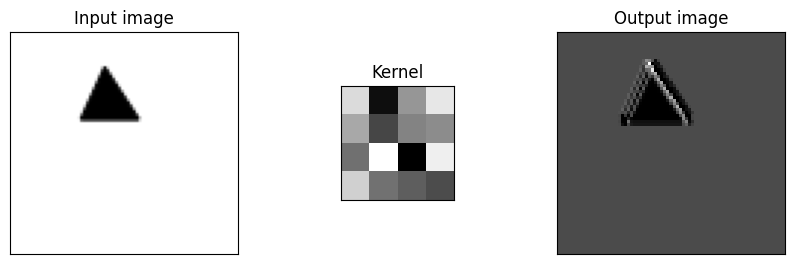

------------------------- Effect of the kernel number 14 -------------------------


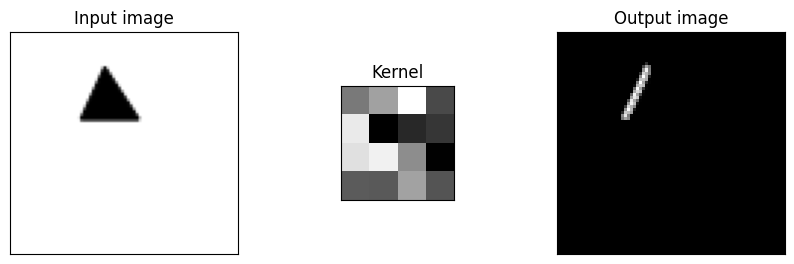

------------------------- Effect of the kernel number 15 -------------------------


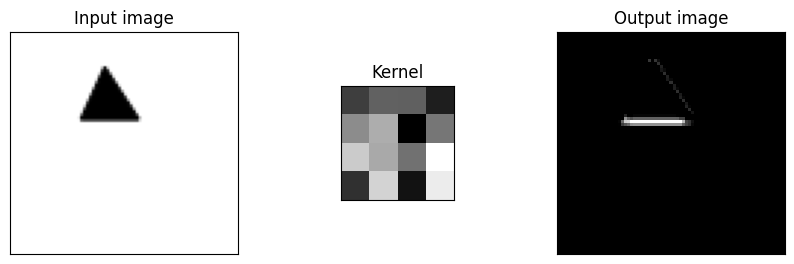

In [ ]:
# First Convolutional Neural Network
layer_number = 0

# The input image has only 1 channel - Black&White picture
channel_number = 0

# Analyzing the impact of all the 16 kernels of the first convolutional layer
for k in np.arange(0, 16):
    print(f"------------------------- Effect of the kernel number {k} -------------------------")
    kernel = model.layers[layer_number].weights[0].numpy()[:, :, channel_number, k]
    plot_convolution(X[1], kernel, activation=True)

#### (2.3.2) Activations 🧨

We have been looking at the activation ("_output image_") only after the **first convolutional layer**.

🤔 What if we want to **visualize the activation of an image after every convolutional layer of the CNN** ?

* 📚 We are going to use the [**Functional API**](https://www.tensorflow.org/guide/keras/functional) from Tensorflow/Keras.



***Step 0️⃣ : Reminders of the CNN's summary***

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 73, 75, 16)     │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 35, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,913 (534.82 KB)

 Trainable params: 45,637 (178.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,276 (356.55 KB)

***Step 1️⃣: listing all the 11 layers' outputs of our CNN***

In [ ]:
layers_outputs = [layer.output for layer in model.layers]
layers_outputs

[<KerasTensor shape=(None, 73, 75, 16), dtype=float32, sparse=False, name=keras_tensor_68>,
 <KerasTensor shape=(None, 36, 37, 16), dtype=float32, sparse=False, name=keras_tensor_70>,
 <KerasTensor shape=(None, 34, 35, 32), dtype=float32, sparse=False, name=keras_tensor_73>,
 <KerasTensor shape=(None, 17, 17, 32), dtype=float32, sparse=False, name=keras_tensor_77>,
 <KerasTensor shape=(None, 15, 15, 64), dtype=float32, sparse=False, name=keras_tensor_82>,
 <KerasTensor shape=(None, 7, 7, 64), dtype=float32, sparse=False, name=keras_tensor_88>,
 <KerasTensor shape=(None, 6, 6, 64), dtype=float32, sparse=False, name=keras_tensor_95>,
 <KerasTensor shape=(None, 3, 3, 64), dtype=float32, sparse=False, name=keras_tensor_103>,
 <KerasTensor shape=(None, 576), dtype=float32, sparse=False, name=keras_tensor_112>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_122>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_133>]

***Step 2️⃣ : Instantiate 11 sub-models re-using already trained weights and biases***
- layer1
- layer1 $ \Rightarrow $ layer2
- layer1 $ \Rightarrow $ layer2 $ \Rightarrow $ layer3
- ...

In [ ]:
activation_models = []
for i in range(len(model.layers)):
    # Get the first `i` layers from the trained model
    layers_to_include = model.layers[:i+1]
    # Build submodel
    inputs = layers.Input(shape=(76, 78, 1)) # dummy input
    x = inputs
    for layer in layers_to_include:
        x = layer(x)

    # Compile again the sub-model to avoid error
    submodel = models.Model(inputs, x)
    submodel.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    activation_models.append(submodel)

***Step 3️⃣ : Compute the outputs of each submodel***

In [ ]:
import tensorflow
tensorflow.keras.__version__

'3.6.0'

In [ ]:
activations = [m.predict(X) for m in activation_models]
len(activations)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


11

In [ ]:
[activation.shape for activation in activations]

[(200, 73, 75, 16),
 (200, 36, 37, 16),
 (200, 34, 35, 32),
 (200, 17, 17, 32),
 (200, 15, 15, 64),
 (200, 7, 7, 64),
 (200, 6, 6, 64),
 (200, 3, 3, 64),
 (200, 576),
 (200, 10),
 (200, 1)]

#### (2.3.3) The final show part

Now that the activations are computed, we can choose one image in the dataset and observe the different "activation images" through each convolutional layer! In other terms, we are now able to observe what the CNN sees for each image!

* 👇 Run the code down below and observe how a triangle was seen through the different convolutional layers.

--- Observing the effect of the convolutional layer number 0... ---

16 kernels were applied and here are all the activations of this Conv2D Layer:


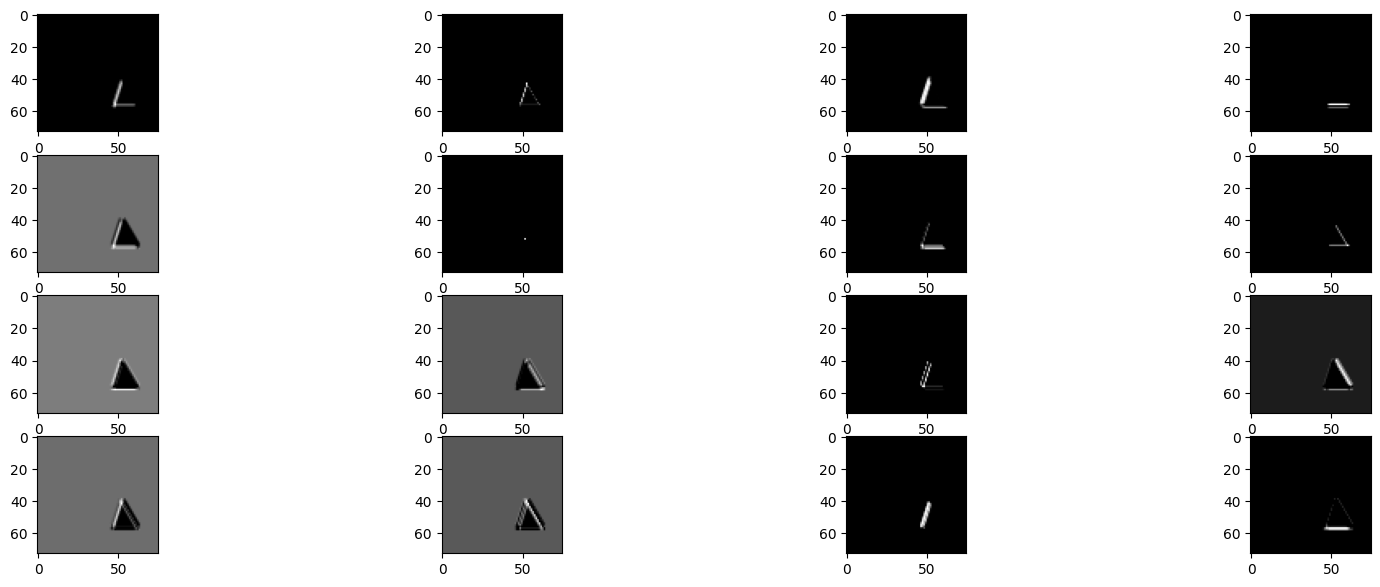

--- Observing the effect of the convolutional layer number 2... ---

32 kernels were applied and here are all the activations of this Conv2D Layer:


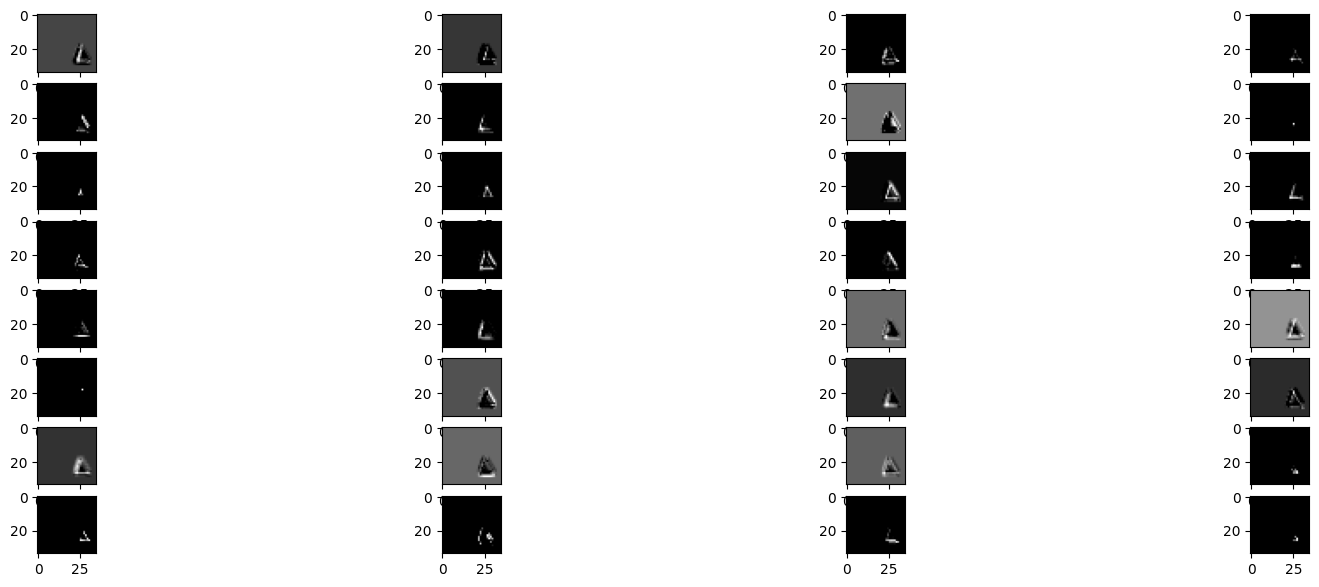

--- Observing the effect of the convolutional layer number 4... ---

64 kernels were applied and here are all the activations of this Conv2D Layer:


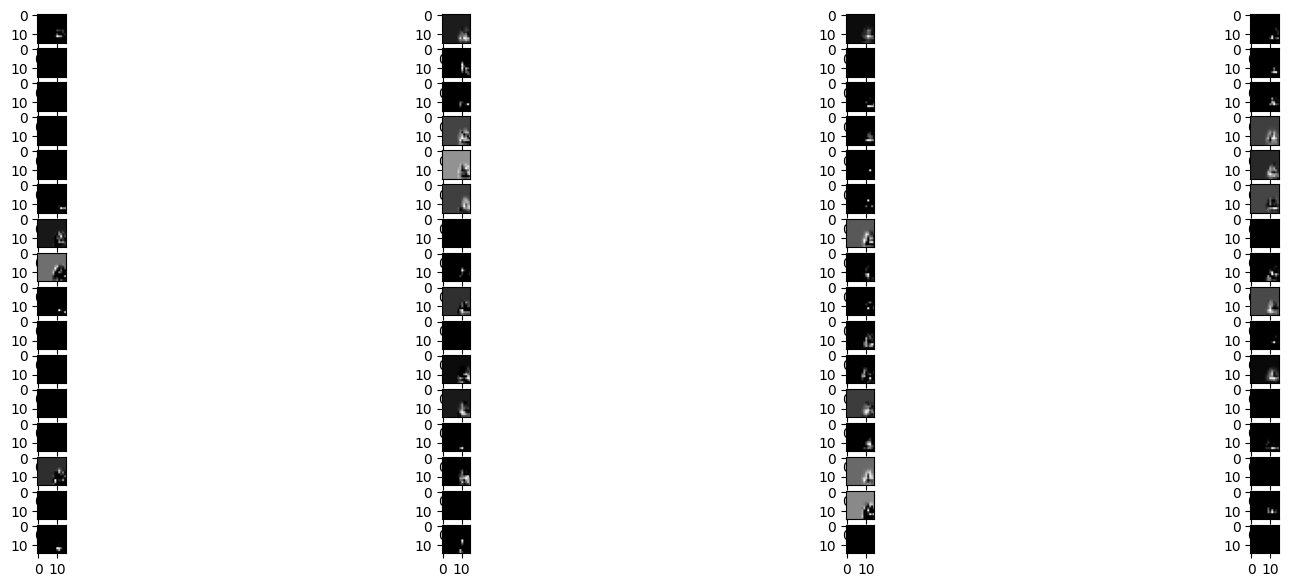

--- Observing the effect of the convolutional layer number 6... ---

64 kernels were applied and here are all the activations of this Conv2D Layer:


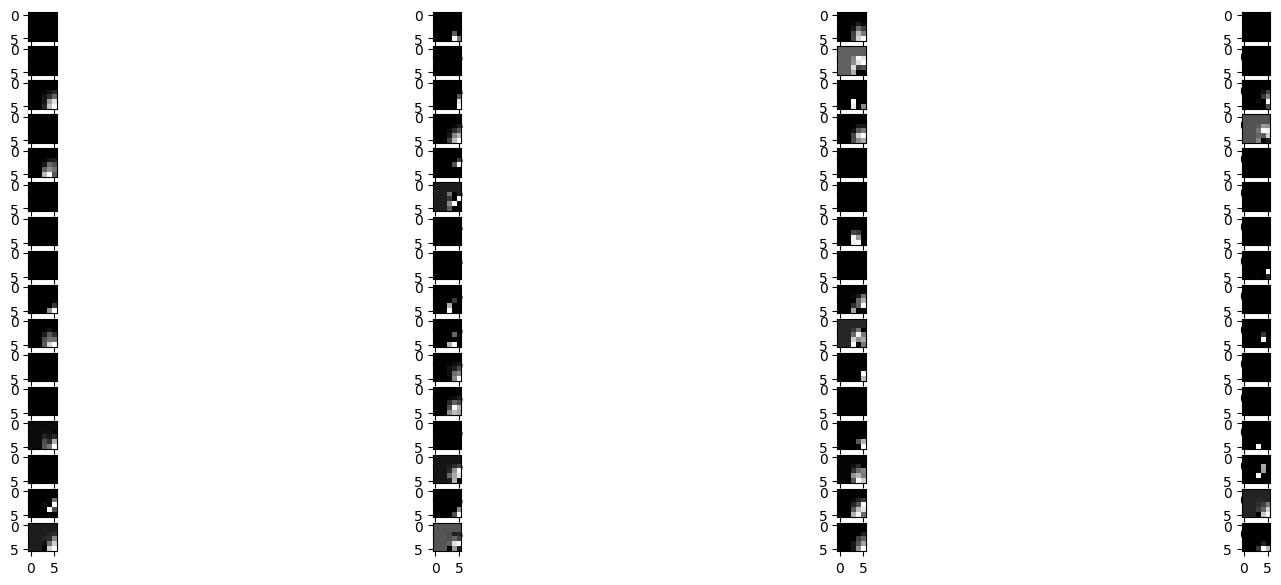

In [ ]:
# Selecting a random triangle
image_number = np.random.choice(np.where(y == 1)[0])

for layer_number in [0,2,4,6]:

    print(f"--- Observing the effect of the convolutional layer number {layer_number}... ---")
    print("")

    temp_number_kernels = model.layers[layer_number].weights[0].shape[-1]
    print(f"{temp_number_kernels} kernels were applied and here are all the activations of this Conv2D Layer:")

    fig, axes = plt.subplots(int(temp_number_kernels/4),4, figsize=(20,7))


    for ax, kernel_number in zip(axes.flat,range(temp_number_kernels)):
        activation = activations[layer_number][image_number][:, :, kernel_number]
        ax.imshow(activation, cmap="gray")

    plt.show()


* 👇 Run the code down below and observe how a circle) was seen through the different convolutional layers.

--- Observing the effect of the convolutional layer number 0... ---

16 kernels were applied and here are all the activations of this Conv2D Layer:


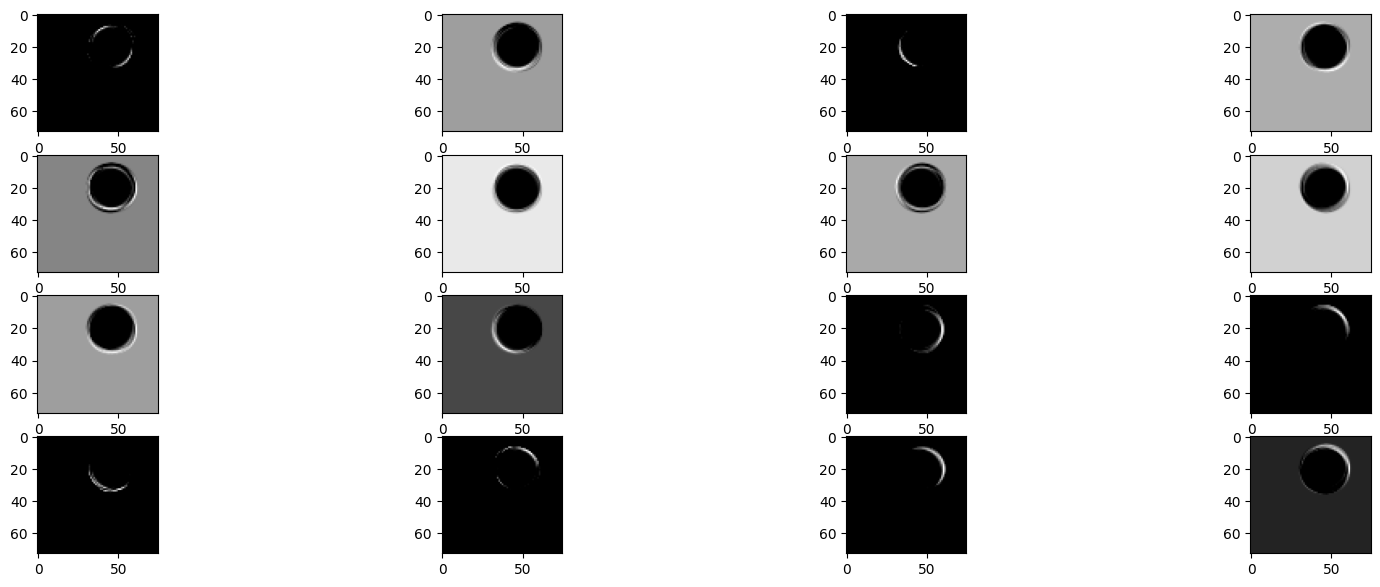

--- Observing the effect of the convolutional layer number 2... ---

32 kernels were applied and here are all the activations of this Conv2D Layer:


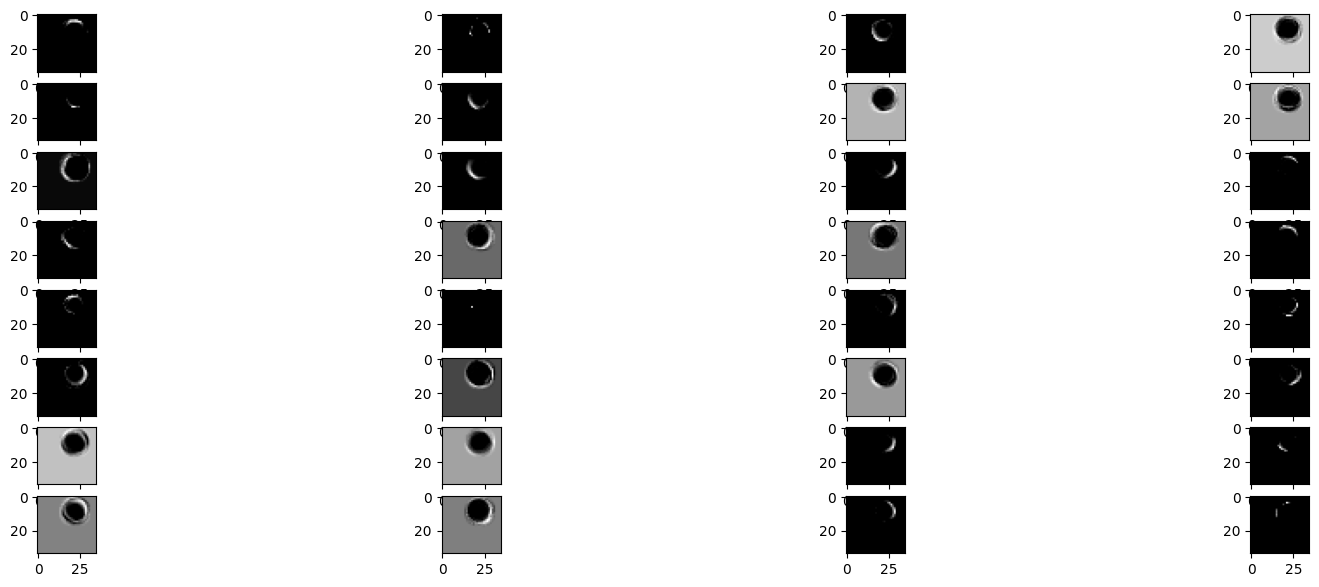

--- Observing the effect of the convolutional layer number 4... ---

64 kernels were applied and here are all the activations of this Conv2D Layer:


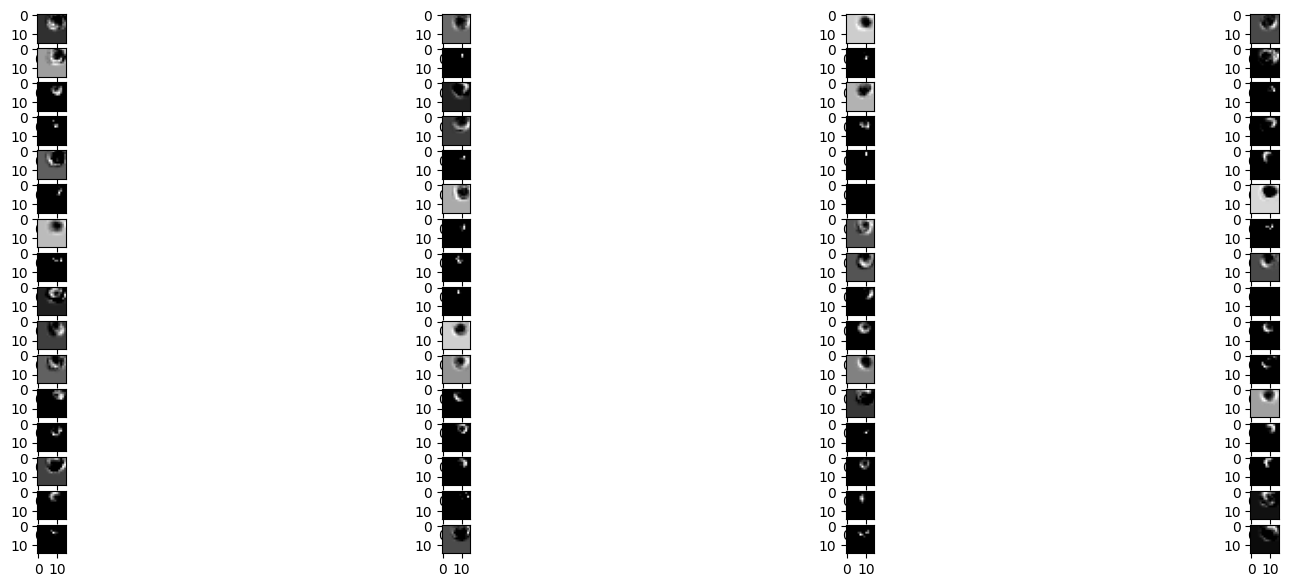

--- Observing the effect of the convolutional layer number 6... ---

64 kernels were applied and here are all the activations of this Conv2D Layer:


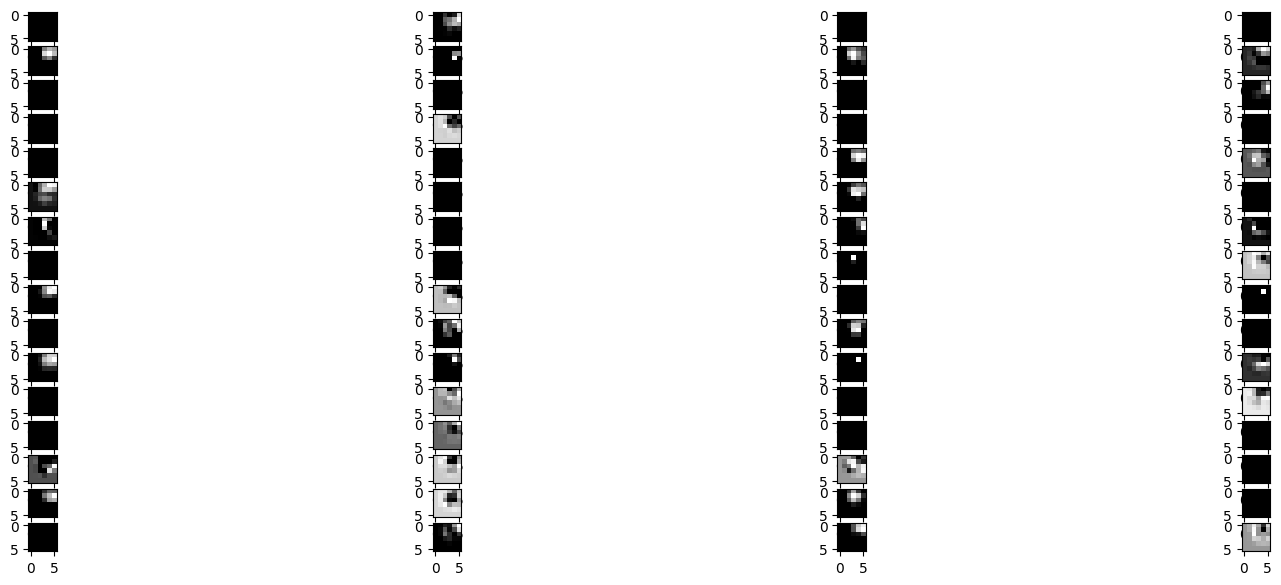

In [ ]:
# Selecting a random triangle
image_number = np.random.choice(np.where(y == 0)[0])

for layer_number in [0,2,4,6]:

    print(f"--- Observing the effect of the convolutional layer number {layer_number}... ---")
    print("")

    temp_number_kernels = model.layers[layer_number].weights[0].shape[-1]
    print(f"{temp_number_kernels} kernels were applied and here are all the activations of this Conv2D Layer:")

    fig, axes = plt.subplots(int(temp_number_kernels/4),4, figsize=(20,7))


    for ax, kernel_number in zip(axes.flat,range(temp_number_kernels)):
        activation = activations[layer_number][image_number][:, :, kernel_number]
        ax.imshow(activation, cmap="gray")

    plt.show()


🧑🏻‍🏫 ***Notes*** 🧑🏻‍🏫

1. Notice how the information of an image **flows** through the Convolutional Neural Network.
2. You should see the picture becoming more and more "abstract", of smaller and smaller "dimensions"

🕹 Feel free to play with the [CNN Explainer](https://poloclub.github.io/cnn-explainer/) from researchers at [Georgia Tech](https://www.gatech.edu/)

## (Appendix) Utils

* The following section simply presents the functions that were used to create the dataset with triangles and circles.

* They are at the end of the notebook just in case you want to further prototype and get better understanding of what is going on.

In [ ]:
def draw_triangle():
    dx = np.random.uniform(0.1, 0.3)
    dy = np.random.uniform(0.1, 0.3)
    noise_x = np.random.uniform(0.0, 0.1)
    noise_y = np.random.uniform(0.0, 0.1)

    x = np.random.uniform(0, 1-dx-noise_x)
    y = np.random.uniform(0, 1-dy)
    X = np.array([[x,y], [x+dx+noise_x,y], [x+dx/2, y+dy+noise_y]])

    t1 = plt.Polygon(X, color='black')
    plt.gca().add_patch(t1)

def draw_circle():
    r = np.random.uniform(0.1, 0.25)
    x = np.random.uniform(0+r, 1-r)
    y = np.random.uniform(0+r, 1-r)

    circle1 = plt.Circle((x, y), r, color='black')
    plt.gcf().gca().add_artist(circle1)

def create_image(form, path):
    plt.figure(figsize=(1, 1))
    if form == 'circle':
        draw_circle()
    elif form == 'triangle':
        draw_triangle()
    plt.axis('off')
    plt.savefig(path, dpi=80, bbox_inches='tight')
    plt.close()


def create_images(path):
    nb_circles = 100
    nb_triangles = 100

    for i in range(nb_circles):
        c_path = os.path.join(path, 'circles', f'circle_{i}.png')
        create_image('circle', c_path)

    for i in range(nb_triangles):
        t_path = os.path.join(path, 'triangles', f'triangle_{i}.png')
        create_image('triangle', t_path)